**Importing libraries**

In [1]:
# Keras e TF

#import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Conv1D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation, AveragePooling2D, Input, Flatten, Dropout
from keras.callbacks import ModelCheckpoint

# Sk-Learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, accuracy_score, classification_report, confusion_matrix

# Base
import os 
from pathlib import Path
from matplotlib import pyplot as plt
import seaborn as sns # 
import numpy as np #
import pandas as pd # 

from keras.utils import load_img

import pydot
import pydotplus
from pydotplus import graphviz

from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau

from custom_resnet import ResNet18


from keras.models import Model
from keras.optimizers import Adam

In [2]:
keras.__version__

'2.10.0'

**Setting path to the dataset**

In [2]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) +
              '\\adni-images-Full-resized160x192'))

In [3]:
print(os.getcwd())

d:\Projects\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\adni-images-Full-resized160x192


# Loading Dataset

In [5]:

data_dir = Path(os.getcwd())

def data_mean_std():
    names = []
    for root, dirs, files in os.walk(data_dir):
        if "train_rand_under" in root:
            for file in files:
                names.append(root + '/' + file)
    
    print(len(names))
                
    array = []
    for name in names:
        img = load_img(name, color_mode = 'grayscale', target_size = (160, 192))

        img_array = np.asarray(img)
        array.append(img_array)
    
    print(img_array.shape) # Correct amount of images

    array = np.asarray(array)
    print(array.shape)
    print(array.mean().shape, array.std().shape)
    return array.mean(), array.std()
""" 
stats_file = open(stats_path, 'r')
stats_lst = stats_file.read().split('\n')
mean = float(stats_lst[0])
std = float(stats_lst[1])"""
mean, std = data_mean_std()

print(mean, std)


66417
(160, 192)
(66417, 160, 192)
() ()
35.813360168106904 45.29735615529554


In [4]:
mean = 35.813360168106904
std = 45.29735615529554

In [5]:
def normalize(x):
    return (x - mean) / std

In [6]:
batch_size = 32 # Batch size

train_path = './train_rand_under'
test_path = './test'
valid_path = './valid'
#rescale = 1./255.
train_datagen = ImageDataGenerator(preprocessing_function = normalize)
test_datagen = ImageDataGenerator(preprocessing_function = normalize)
valid_datagen = ImageDataGenerator(preprocessing_function = normalize)

In [7]:
train_data = train_datagen.flow_from_directory(
        train_path,
        color_mode = 'grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode='categorical')

Found 66417 images belonging to 3 classes.


In [8]:
validation_data = valid_datagen.flow_from_directory(
        valid_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        seed=123,
        shuffle=True,
        class_mode='categorical')

Found 18024 images belonging to 3 classes.


In [9]:
# Test set
test_data = test_datagen.flow_from_directory(
        test_path,
        color_mode='grayscale',
        target_size=(192, 160),  # Lo inserisco per precauzione
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 10567 images belonging to 3 classes.


In [10]:
train_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [11]:
validation_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [12]:
test_data.class_indices

{'ad': 0, 'mci': 1, 'nor': 2}

In [13]:
train_ad = len(os.listdir(os.getcwd() + '\\train_rand_under\\ad'))
train_nor = len(os.listdir(os.getcwd() + '\\train_rand_under\\nor'))
train_mci = len(os.listdir(os.getcwd() + '\\train_rand_under\\mci'))
train_tot = train_ad + train_nor + train_mci
print(train_ad/train_tot, train_nor/train_tot, train_mci/train_tot)

0.3333333333333333 0.3333333333333333 0.3333333333333333


In [14]:
test_ad = len(os.listdir(os.getcwd() + '\\test\\ad'))
test_nor = len(os.listdir(os.getcwd() + '\\test\\nor'))
test_mci = len(os.listdir(os.getcwd() + '\\test\\mci'))
test_tot = test_ad + test_nor + test_mci
print(test_ad/test_tot, test_nor/test_tot, test_mci/test_tot)

0.22504021955143372 0.20762751963660453 0.5673322608119618


In [15]:
valid_ad = len(os.listdir(os.getcwd() + '\\valid\\ad'))
valid_nor = len(os.listdir(os.getcwd() + '\\valid\\nor'))
valid_mci = len(os.listdir(os.getcwd() + '\\valid\\mci'))
valid_tot = valid_ad + valid_nor + valid_mci
print(valid_ad/valid_tot, valid_nor/valid_tot, valid_mci/valid_tot)

0.22253661784287618 0.37377940523746117 0.4036839769196627


# Model Definition

Changing the folder to data path to save weights into

In [16]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute()) + '\\scripts\\3_Resnet18_first'))

In [17]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\scripts\\3_Resnet18_first'

In [18]:
METRICS = [ 
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.TopKCategoricalAccuracy(name='top 2 accuracy', k=2),
      keras.metrics.TopKCategoricalAccuracy(name='top 3 accuracy', k=3),
      keras.metrics.TopKCategoricalAccuracy(name='top 5 accuracy', k=5)
]

In [19]:
early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [24]:
tb = TensorBoard(log_dir =os.getcwd() + '\\rand_under\\logs_rand_under', write_graph = True)

lr_reducer = ReduceLROnPlateau(monitor='loss', factor=np.sqrt(0.1), patience=10, cooldown=0, min_lr=1e-5)

model_chkp = ModelCheckpoint(filepath=os.getcwd() + '\\rand_under\\best_model_rand_under',
                            # monitor='val_quadratic_kappa_score',
                            monitor='val_accuracy',
                            save_best_only=True, save_weights_only=True, mode='max')

#resnet = ResNet18()
#resnet = ResNet18(classes=3, input_shape=(160, 192))
resnet = ResNet18(classes=3)


#model = keras.applications.resnet50.ResNet50(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
#model.summary()

#resnet.layers.pop()
#for layer in resnet.layers:
#    layer.trainable = False

x = resnet.layers[-1].output

x = Dropout(0.25)(x)

x = Dense(3, activation = 'softmax')(x)


ft_resnet = Model(resnet.input, x)
ft_resnet.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = METRICS)

print("model loaded")

ft_resnet.summary()

<class 'keras.engine.keras_tensor.KerasTensor'>
model loaded
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 192, 160, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 166, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 96, 80, 64)   3200        ['conv1_pad[0][0]']              
                                                                                                  
 bn_conv1 (BatchNormalization) 

Changing back the folder to data path

In [25]:
os.chdir(Path(str(Path(os.getcwd()).parent.absolute().parent.absolute()) + '\\adni-images-Full-resized160x192'))
os.getcwd()

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'd:\\Projects\\adni-images-Full-resized160x192'

In [26]:
os.getcwd()

'd:\\Projects\\ADNI-brain-MRI-alzheimer-classification-and-GAN-generation\\adni-images-Full-resized160x192'

In [27]:
version = "v1"
epochs = 100

print(train_tot, valid_tot)

train_steps = np.ceil(train_tot/batch_size)
valid_steps = np.ceil(valid_tot/batch_size)

print (train_steps, valid_steps)

#fit_generator

history_dcnn = ft_resnet.fit(train_data, 
                             steps_per_epoch=train_steps,
                             epochs=epochs,
                             workers = 4,
                             callbacks = [tb, model_chkp, lr_reducer, early_stopper],
                             validation_data = validation_data, 
                             validation_steps = valid_steps)


66417 18024
2076.0 564.0
Epoch 1/100
2076/2076 [==============================] - 141s 66ms/step - loss: 1.0175 - accuracy: 0.6924 - precision: 0.8030 - recall: 0.5809 - auc: 0.8842 - top 2 accuracy: 0.8838 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000 - val_loss: 1.2654 - val_accuracy: 0.4288 - val_precision: 0.4465 - val_recall: 0.3604 - val_auc: 0.6256 - val_top 2 accuracy: 0.7821 - val_top 3 accuracy: 1.0000 - val_top 5 accuracy: 1.0000 - lr: 0.0010
Epoch 2/100
2076/2076 [==============================] - 143s 69ms/step - loss: 0.7781 - accuracy: 0.6453 - precision: 0.6972 - recall: 0.5540 - auc: 0.8288 - top 2 accuracy: 0.9010 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000 - val_loss: 2.1074 - val_accuracy: 0.3337 - val_precision: 0.3325 - val_recall: 0.3122 - val_auc: 0.5158 - val_top 2 accuracy: 0.6839 - val_top 3 accuracy: 1.0000 - val_top 5 accuracy: 1.0000 - lr: 0.0010
Epoch 3/100
2076/2076 [==============================] - 141s 68ms/step - loss: 0.5302 - accuracy: 0.

KeyboardInterrupt: 

In [28]:
arch_name = 'bs_{}'.format(batch_size)

continue_model_path = '..\\models\\best_model_rand_under\\' + '{}_{}_{}_eps.h5'.format(version, arch_name, epochs)
ft_resnet.save(continue_model_path)
np.save(f'..\\models\\best_model_rand_under\\{version}_{arch_name}_{epochs}_eps.npy',
        history_dcnn.history)

NameError: name 'history_dcnn' is not defined

NameError: name 'history_dcnn' is not defined

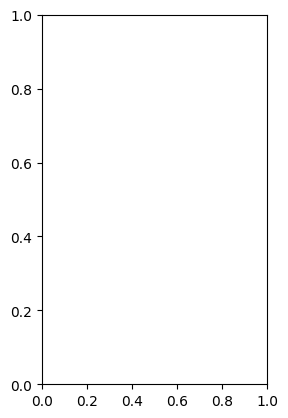

In [29]:
# Visualization of the learning curves

# Loss
plt.subplot(1, 2, 1)
plt.plot(history_dcnn.history['loss'])
plt.plot(history_dcnn.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_dcnn.history['accuracy'])
plt.plot(history_dcnn.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'validation'])

# Load Model

In [8]:
#os.chdir('C:/Users/marco/Desktop/Local_Documents/models/NoBalance')

In [16]:
# Load model
net_dcnn = keras.models.load_model("..\\models\\best_model_rand_under\\v1_bs_32_10_eps.h5")

In [17]:
# Load hystory and convert to dict
history = np.load('..\\models\\best_model_rand_under\\v1_bs_32_10_eps.npy', allow_pickle=True).item()

# Model Evaluation

In [18]:
# Set visualization size for figures 
plt.rcParams['figure.figsize'] = [5,5] # width, height

In [44]:
CATEGORIES = "ad", "mci","nor"

In [28]:
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'auc', 'top 2 accuracy', 'top 3 accuracy', 'top 5 accuracy', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc', 'val_top 2 accuracy', 'val_top 3 accuracy', 'val_top 5 accuracy', 'lr'])

In [29]:
test_data = validation_data

In [41]:
history['accuracy'][:1+1]

[0.5128205418586731, 0.6809400916099548]

In [45]:
%matplotlib inline

def print_graph(item, index, history):
    plt.figure()
    train_values = history[item][:index+5]
    plt.plot(train_values)
    test_values = history['val_' + item][:index+5]
    plt.plot(test_values)
    plt.legend(['training','validation'])
    plt.title('Training and validation '+ item)
    plt.xlabel('epoch')
    plt.show()
    plot = '{}.png'.format(item)
    plt.savefig(plot)

In [46]:
def test_set_results(pred_value, n=1):    
    y_test = test_data.labels
    X_test, _ = test_data.next()
    
    corr_pred = confusion_matrix(y_test, pred_value)
    fig=plt.figure(figsize=(10, 8))
    ax = plt.axes()
    
    sns.heatmap(corr_pred,annot=True, fmt="d",cmap="Purples", xticklabels=CATEGORIES, yticklabels=CATEGORIES)
    ax.set_title('Confusione Matrix')
    plt.show()
    
    n_correct = int(corr_pred[0][0] + corr_pred[1][1] + corr_pred[2][2])
    print('...'*15)

    print('> Correct Predictions:', n_correct)
    
    n_wrongs = len(y_test) - n_correct
    print('> Wrong Predictions:', n_wrongs)
    print('...'*15)
    
    print(classification_report(test_data.labels, pred_value, target_names=CATEGORIES))

In [47]:
def printResults(name, model):
    predictions = model.predict(test_data, verbose=1)
    preds = np.argmax(predictions, axis=1)
    test_set_results(preds)

In [48]:
def model_summary(model, history, name):
    val_acc = history['val_accuracy'] #validation accuracy history
    index= val_acc.index(max(val_acc))
    print('Best Epochs:', index)


    test_loss, test_accuracy, test_precision, test_recall, auc, _, _, _ = model.evaluate(test_data, verbose=1)

    train_accuracy = history['accuracy'][index]
    train_loss = history['loss'][index]

    print_graph('loss', index, history)
    print_graph('accuracy', index, history)

    print('---'*15) 
    print(name)
    print('> Accuracy on train:',round(train_accuracy, 2), 
            '\tLoss on train:', round(train_loss,2))
    

    print('> Accuracy on test:',round(test_accuracy, 2),
            '\tLoss on test:',round(test_loss,2))

    print('---'*15)
    print('> predicting test')
    print('---'*15)

    printResults(name, model)

Best Epochs: 1
564/564 [==============================] - 24s 42ms/step - loss: 3.5593 - accuracy: 0.4238 - precision: 0.4250 - recall: 0.4191 - auc: 0.5949 - top 2 accuracy: 0.7663 - top 3 accuracy: 1.0000 - top 5 accuracy: 1.0000


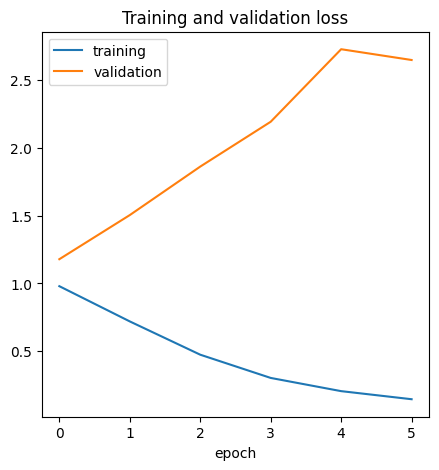

<Figure size 500x500 with 0 Axes>

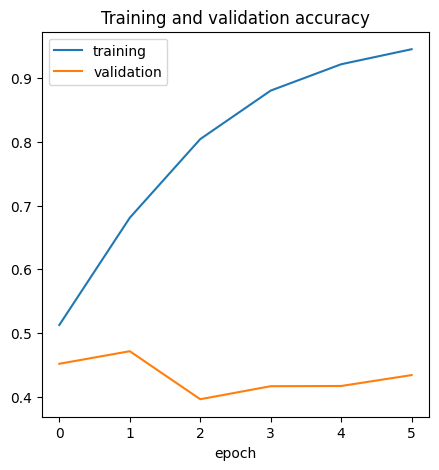

---------------------------------------------
DCCN - Random Undersampling
> Accuracy on train: 0.68 	Loss on train: 0.72
> Accuracy on test: 0.42 	Loss on test: 3.56
---------------------------------------------
> predicting test
---------------------------------------------
564/564 [==============================] - 24s 42ms/step


<Figure size 500x500 with 0 Axes>

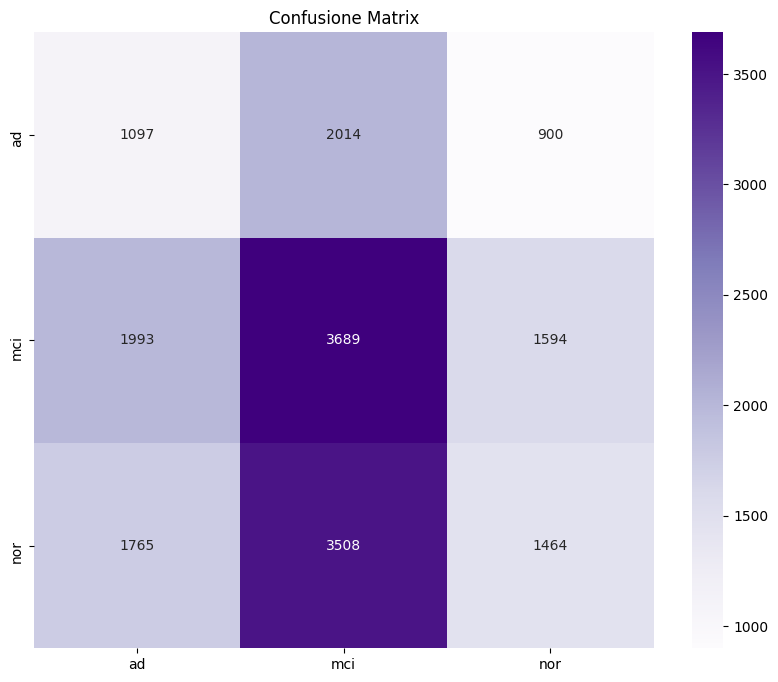

.............................................
> Correct Predictions: 6250
> Wrong Predictions: 11774
.............................................
              precision    recall  f1-score   support

          ad       0.23      0.27      0.25      4011
         mci       0.40      0.51      0.45      7276
         nor       0.37      0.22      0.27      6737

    accuracy                           0.35     18024
   macro avg       0.33      0.33      0.32     18024
weighted avg       0.35      0.35      0.34     18024



In [49]:
model_summary(net_dcnn, history, 'DCCN - Random Undersampling')